In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/auto-insurance-claims-data/insurance_claims.csv


In [2]:
# necessary imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [3]:
df = pd.read_csv('../input/auto-insurance-claims-data/insurance_claims.csv')

In [4]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [5]:
# we can see some missing values denoted by '?' so lets replace missing values with np.nan

df.replace('?', np.nan, inplace = True)

In [6]:
df.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,_c39
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,0.0
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,NaN
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,NaN
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,NaN
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,NaN
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,NaN
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,NaN
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,NaN


Data Pre-Processing



In [7]:
# missing values
df.isna().sum()

months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                  178
incident_severity                 0
authorities_contacted             0
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage             

Visualizing Missing Values

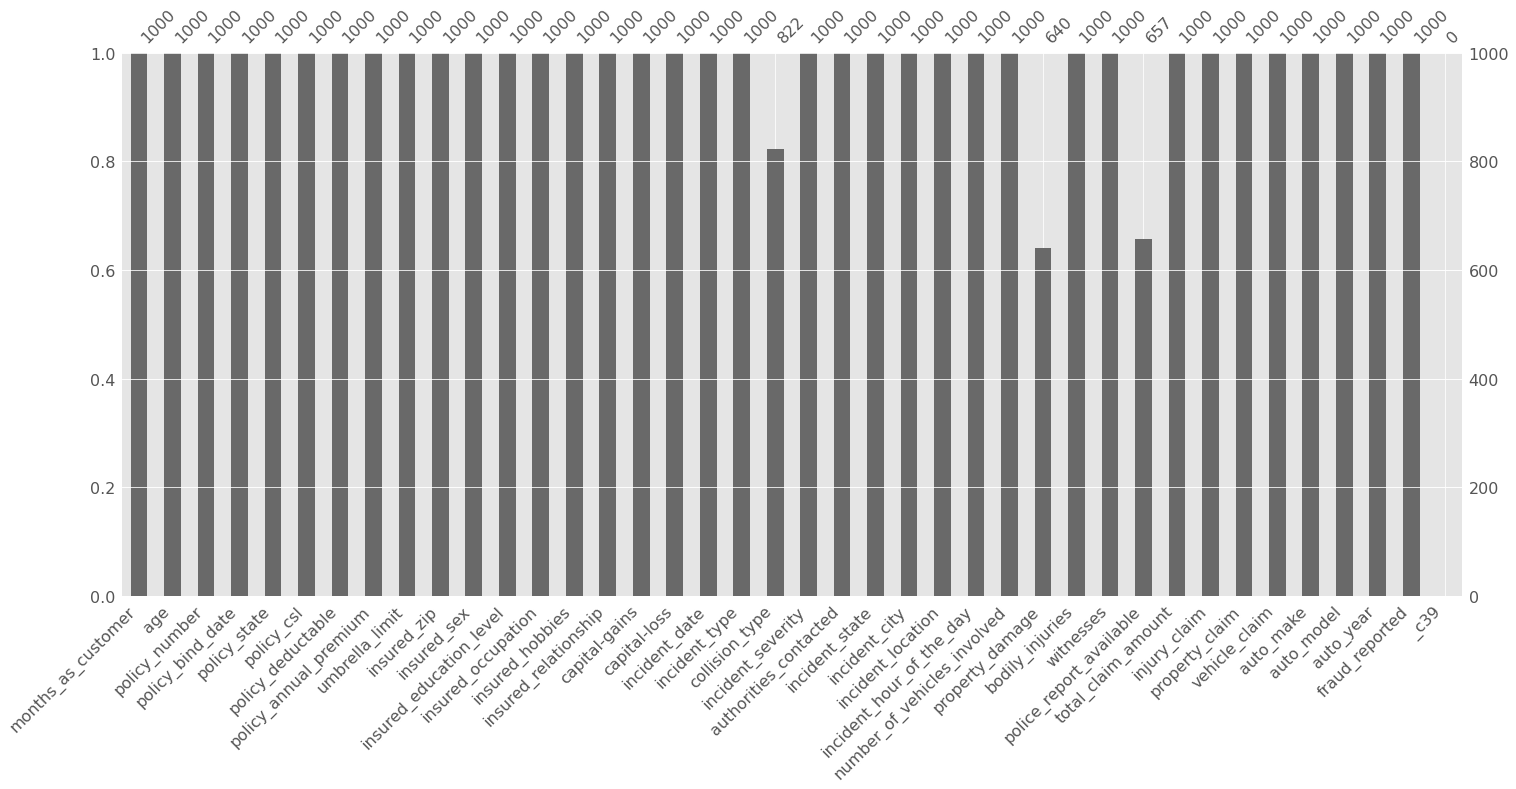

In [8]:
import missingno as msno

msno.bar(df)
plt.show()

Handling missing values

In [9]:
df['collision_type'] = df['collision_type'].fillna(df['collision_type'].mode()[0])

In [10]:
df['property_damage'] = df['property_damage'].fillna(df['property_damage'].mode()[0])

In [11]:
df['police_report_available'] = df['police_report_available'].fillna(df['police_report_available'].mode()[0])

In [12]:
df.isna().sum()

months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted             0
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage             

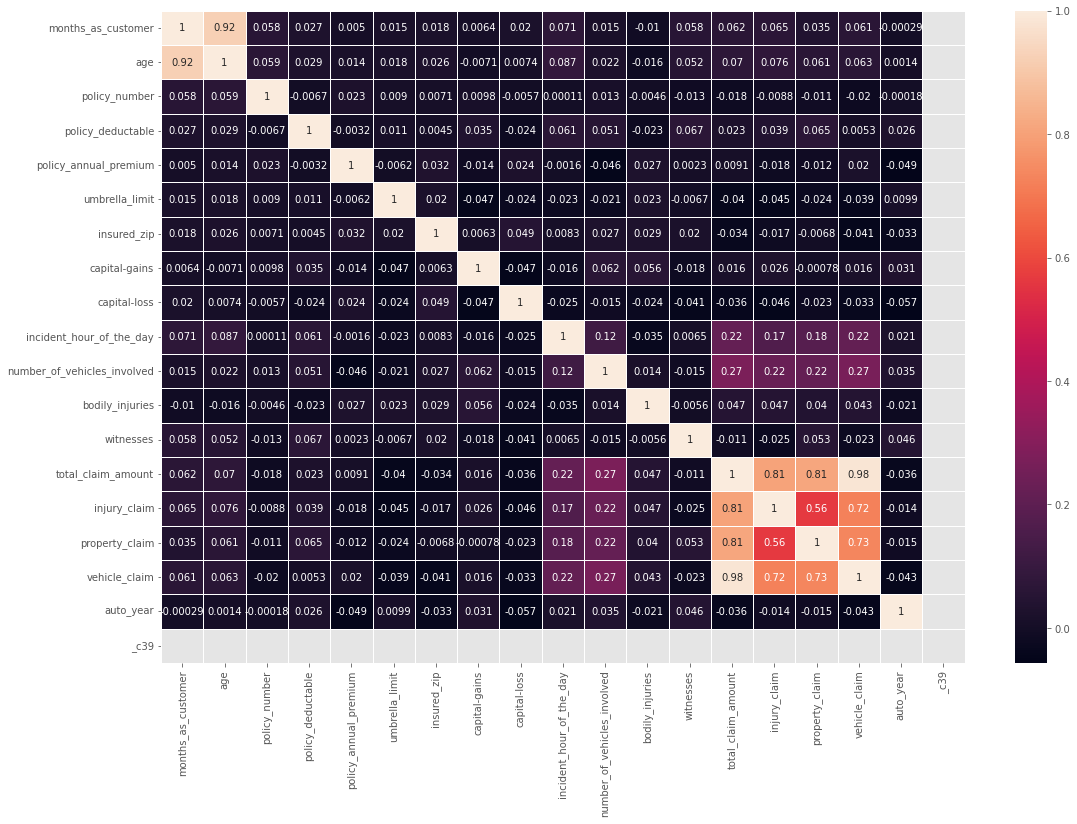

In [13]:
# heatmap

plt.figure(figsize = (18, 12))

corr = df.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [14]:
df.nunique()

months_as_customer              391
age                              46
policy_number                  1000
policy_bind_date                951
policy_state                      3
policy_csl                        3
policy_deductable                 3
policy_annual_premium           991
umbrella_limit                   11
insured_zip                     995
insured_sex                       2
insured_education_level           7
insured_occupation               14
insured_hobbies                  20
insured_relationship              6
capital-gains                   338
capital-loss                    354
incident_date                    60
incident_type                     4
collision_type                    3
incident_severity                 4
authorities_contacted             5
incident_state                    7
incident_city                     7
incident_location              1000
incident_hour_of_the_day         24
number_of_vehicles_involved       4
property_damage             

In [15]:
# dropping columns which are not necessary for prediction

to_drop = ['policy_number','policy_bind_date','policy_state','insured_zip','incident_location','incident_date',
           'incident_state','incident_city','insured_hobbies','auto_make','auto_model','auto_year', '_c39']

df.drop(to_drop, inplace = True, axis = 1)

In [16]:
df.head()

,months_as_customer,age,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_relationship,...,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,fraud_reported
0,328,48,250/500,1000,1406.91,0,MALE,MD,craft-repair,husband,...,1,YES,1,2,YES,71610,6510,13020,52080,Y
1,228,42,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,other-relative,...,1,NO,0,0,NO,5070,780,780,3510,Y
2,134,29,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,own-child,...,3,NO,2,3,NO,34650,7700,3850,23100,N
3,256,41,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,unmarried,...,1,NO,1,2,NO,63400,6340,6340,50720,Y
4,228,44,500/1000,1000,1583.91,6000000,MALE,Associate,sales,unmarried,...,1,NO,0,1,NO,6500,1300,650,4550,N


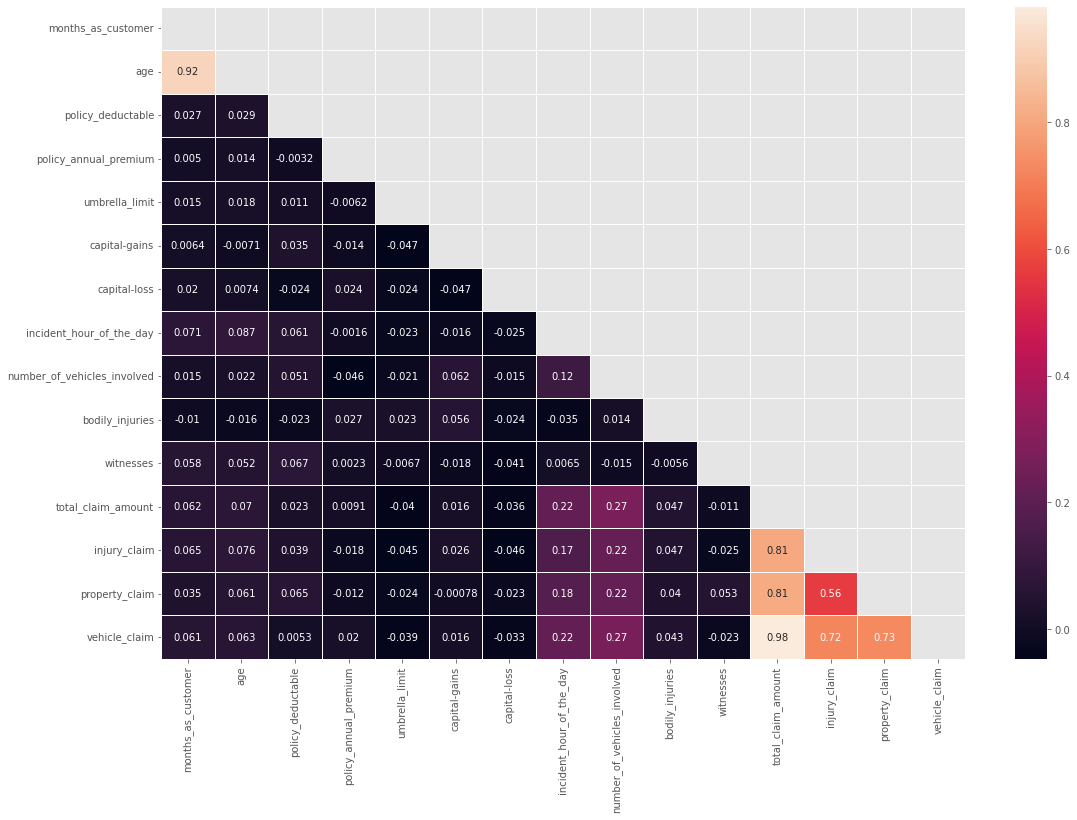

In [17]:
# checking for multicollinearity

plt.figure(figsize = (18, 12))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(data = corr, mask = mask, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

From the above plot, we can see that there is high correlation between age and months_as_customer.We will drop the "Age" column. Also there is high correlation between total_clam_amount, injury_claim, property_claim, vehicle_claim as total claim is the sum of all others. So we will drop the total claim column.

In [18]:
df.drop(columns = ['age', 'total_claim_amount'], inplace = True, axis = 1)

In [19]:
df.head()

,months_as_customer,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_relationship,capital-gains,...,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,injury_claim,property_claim,vehicle_claim,fraud_reported
0,328,250/500,1000,1406.91,0,MALE,MD,craft-repair,husband,53300,...,5,1,YES,1,2,YES,6510,13020,52080,Y
1,228,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,other-relative,0,...,8,1,NO,0,0,NO,780,780,3510,Y
2,134,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,own-child,35100,...,7,3,NO,2,3,NO,7700,3850,23100,N
3,256,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,unmarried,48900,...,5,1,NO,1,2,NO,6340,6340,50720,Y
4,228,500/1000,1000,1583.91,6000000,MALE,Associate,sales,unmarried,66000,...,20,1,NO,0,1,NO,1300,650,4550,N


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   policy_csl                   1000 non-null   object 
 2   policy_deductable            1000 non-null   int64  
 3   policy_annual_premium        1000 non-null   float64
 4   umbrella_limit               1000 non-null   int64  
 5   insured_sex                  1000 non-null   object 
 6   insured_education_level      1000 non-null   object 
 7   insured_occupation           1000 non-null   object 
 8   insured_relationship         1000 non-null   object 
 9   capital-gains                1000 non-null   int64  
 10  capital-loss                 1000 non-null   int64  
 11  incident_type                1000 non-null   object 
 12  collision_type               1000 non-null   object 
 13  incident_severity  

In [21]:
# separating the feature and target columns

X = df.drop('fraud_reported', axis = 1)
y = df['fraud_reported']

Encoding Categorical columns

In [22]:
# extracting categorical columns
cat_df = X.select_dtypes(include = ['object'])

In [23]:
cat_df.head()

,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_relationship,incident_type,collision_type,incident_severity,authorities_contacted,property_damage,police_report_available
0,250/500,MALE,MD,craft-repair,husband,Single Vehicle Collision,Side Collision,Major Damage,Police,YES,YES
1,250/500,MALE,MD,machine-op-inspct,other-relative,Vehicle Theft,Rear Collision,Minor Damage,Police,NO,NO
2,100/300,FEMALE,PhD,sales,own-child,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NO,NO
3,250/500,FEMALE,PhD,armed-forces,unmarried,Single Vehicle Collision,Front Collision,Major Damage,Police,NO,NO
4,500/1000,MALE,Associate,sales,unmarried,Vehicle Theft,Rear Collision,Minor Damage,None,NO,NO


In [24]:
# printing unique values of each column
for col in cat_df.columns:
    print(f"{col}: \n{cat_df[col].unique()}\n")

policy_csl: 
['250/500' '100/300' '500/1000']

insured_sex: 
['MALE' 'FEMALE']

insured_education_level: 
['MD' 'PhD' 'Associate' 'Masters' 'High School' 'College' 'JD']

insured_occupation: 
['craft-repair' 'machine-op-inspct' 'sales' 'armed-forces' 'tech-support'
 'prof-specialty' 'other-service' 'priv-house-serv' 'exec-managerial'
 'protective-serv' 'transport-moving' 'handlers-cleaners' 'adm-clerical'
 'farming-fishing']

insured_relationship: 
['husband' 'other-relative' 'own-child' 'unmarried' 'wife' 'not-in-family']

incident_type: 
['Single Vehicle Collision' 'Vehicle Theft' 'Multi-vehicle Collision'
 'Parked Car']

collision_type: 
['Side Collision' 'Rear Collision' 'Front Collision']

incident_severity: 
['Major Damage' 'Minor Damage' 'Total Loss' 'Trivial Damage']

authorities_contacted: 
['Police' 'None' 'Fire' 'Other' 'Ambulance']

property_damage: 
['YES' 'NO']

police_report_available: 
['YES' 'NO']



In [25]:
cat_df = pd.get_dummies(cat_df, drop_first = True)

In [26]:
cat_df.head()

,policy_csl_250/500,policy_csl_500/1000,insured_sex_MALE,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,insured_occupation_armed-forces,...,collision_type_Side Collision,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,property_damage_YES,police_report_available_YES
0,1,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,1,1
1,1,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [27]:
# extracting the numerical columns

num_df = X.select_dtypes(include = ['int64'])

In [28]:
num_df.head()

,months_as_customer,policy_deductable,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,injury_claim,property_claim,vehicle_claim
0,328,1000,0,53300,0,5,1,1,2,6510,13020,52080
1,228,2000,5000000,0,0,8,1,0,0,780,780,3510
2,134,2000,5000000,35100,0,7,3,2,3,7700,3850,23100
3,256,2000,6000000,48900,-62400,5,1,1,2,6340,6340,50720
4,228,1000,6000000,66000,-46000,20,1,0,1,1300,650,4550


In [29]:
# combining the Numerical and Categorical dataframes to get the final dataset

X = pd.concat([num_df, cat_df], axis = 1)

In [30]:
X.head()

,months_as_customer,policy_deductable,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,injury_claim,...,collision_type_Side Collision,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,property_damage_YES,police_report_available_YES
0,328,1000,0,53300,0,5,1,1,2,6510,...,1,0,0,0,0,0,0,1,1,1
1,228,2000,5000000,0,0,8,1,0,0,780,...,0,1,0,0,0,0,0,1,0,0
2,134,2000,5000000,35100,0,7,3,2,3,7700,...,0,1,0,0,0,0,0,1,0,0
3,256,2000,6000000,48900,-62400,5,1,1,2,6340,...,0,0,0,0,0,0,0,1,0,0
4,228,1000,6000000,66000,-46000,20,1,0,1,1300,...,0,1,0,0,0,1,0,0,0,0


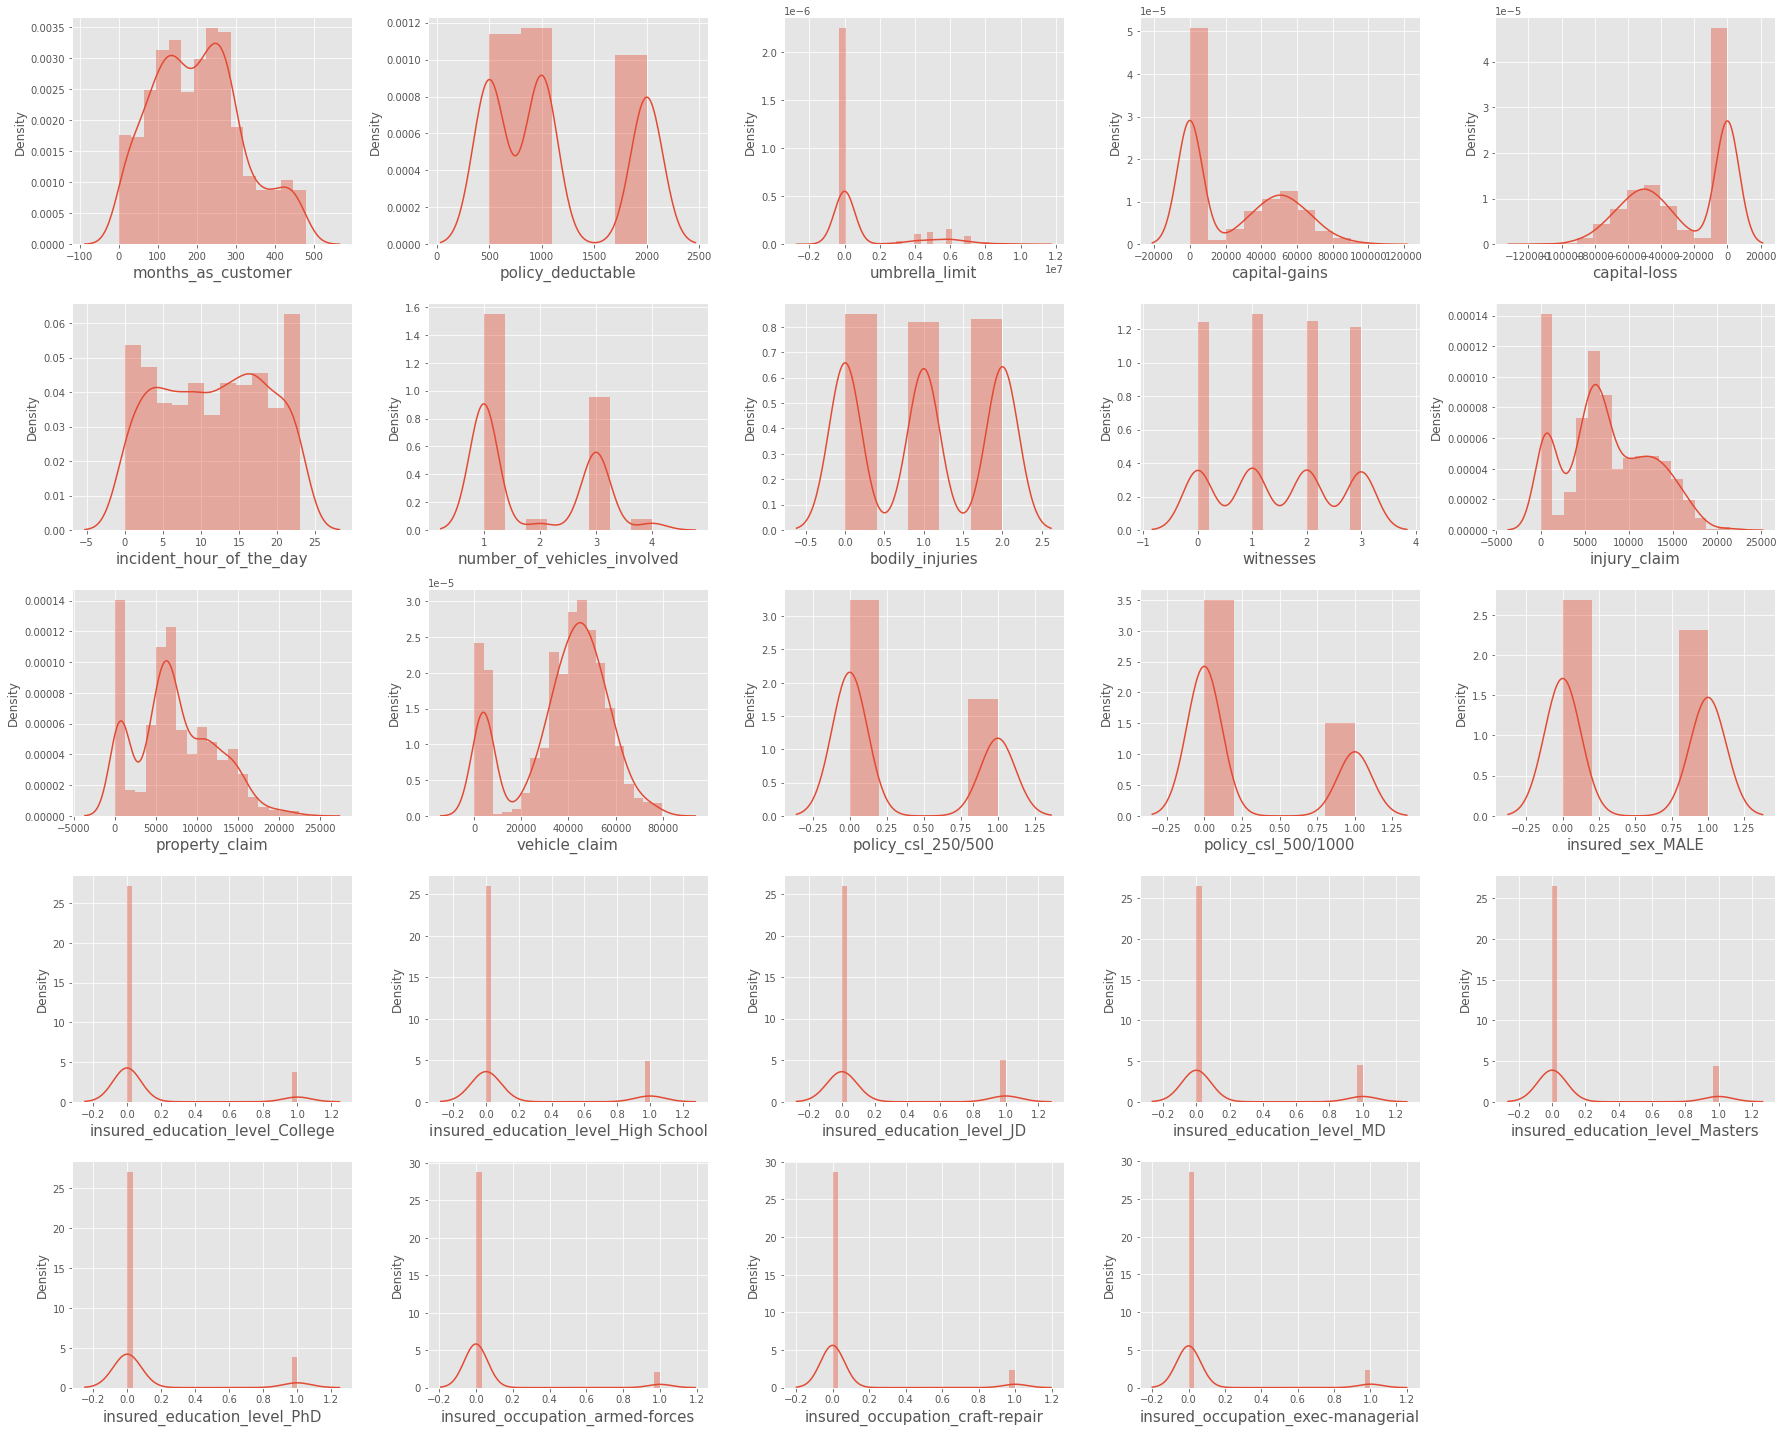

In [31]:
plt.figure(figsize = (25, 20))
plotnumber = 1

for col in X.columns:
    if plotnumber <= 24:
        ax = plt.subplot(5, 5, plotnumber)
        sns.distplot(X[col])
        plt.xlabel(col, fontsize = 15)
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

Data looks good, let's check for outliers.

Outliers Detection

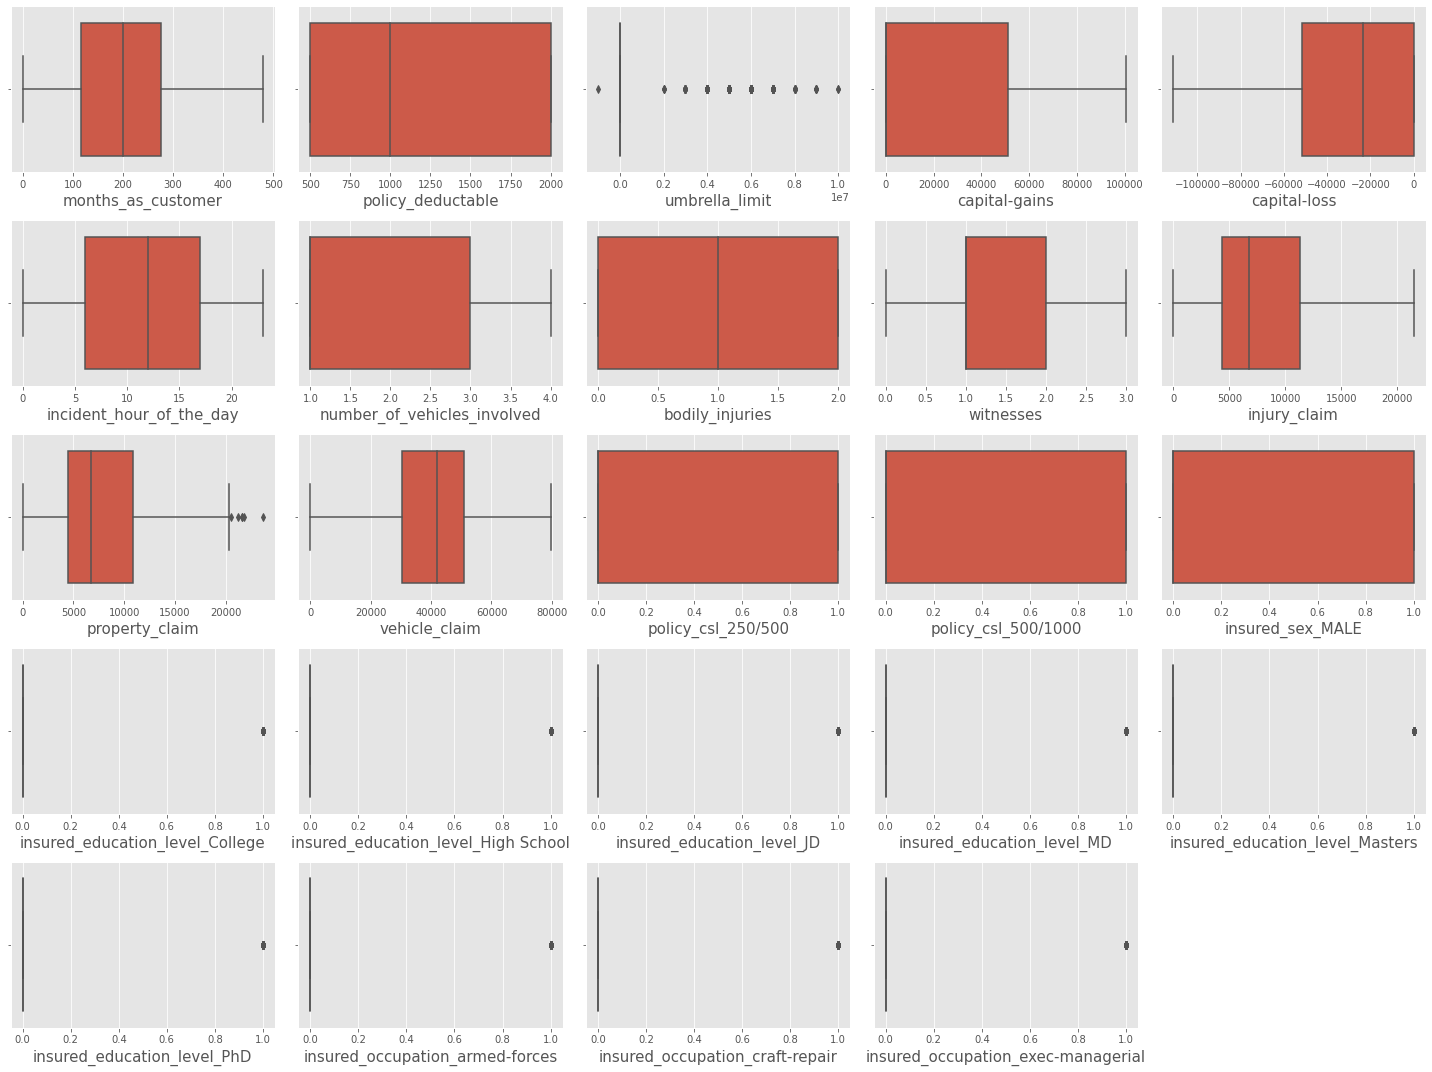

In [32]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for col in X.columns:
    if plotnumber <= 24:
        ax = plt.subplot(5, 5, plotnumber)
        sns.boxplot(X[col])
        plt.xlabel(col, fontsize = 15)
    
    plotnumber += 1
plt.tight_layout()
plt.show()

utliers are present in some numerical columns we will scale numerical columns later

In [33]:
# splitting data into training set and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [34]:
X_train.head()

,months_as_customer,policy_deductable,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,injury_claim,...,collision_type_Side Collision,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,property_damage_YES,police_report_available_YES
362,150,1000,0,0,0,8,1,0,2,450,...,0,0,0,1,0,1,0,0,1,0
356,229,2000,0,65600,0,14,3,1,1,11460,...,1,0,0,0,0,0,1,0,1,1
843,297,1000,0,0,-71400,18,3,0,2,6870,...,0,0,0,0,0,0,1,0,0,0
240,249,1000,0,0,0,16,1,0,0,5350,...,0,0,0,0,1,0,0,0,0,1
467,411,1000,0,0,0,23,3,0,0,3510,...,1,0,0,0,0,0,0,0,0,0


In [35]:
num_df = X_train[['months_as_customer', 'policy_deductable', 'umbrella_limit',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'injury_claim', 'property_claim',
       'vehicle_claim']]

In [36]:
# Scaling the numeric values in the dataset

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_df)

In [37]:
scaled_num_df = pd.DataFrame(data = scaled_data, columns = num_df.columns, index = X_train.index)
scaled_num_df.head()

,months_as_customer,policy_deductable,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,injury_claim,property_claim,vehicle_claim
362,-0.464225,-0.240074,-0.487149,-0.907401,0.968293,-0.509030,-0.824489,-1.239878,0.431302,-1.433054,-1.451650,-1.819095
356,0.237513,1.389389,-0.487149,1.421805,0.968293,0.343458,1.132368,-0.029060,-0.462280,0.847894,-0.342725,0.742482
843,0.841541,-0.240074,-0.487149,-0.907401,-1.573476,0.911784,1.132368,-1.239878,0.431302,-0.103019,-1.546160,0.556651
240,0.415168,-0.240074,-0.487149,-0.907401,0.968293,0.627621,-0.824489,-1.239878,-1.355861,-0.417918,-0.422534,0.274168
467,1.854175,-0.240074,-0.487149,-0.907401,0.968293,1.622191,1.132368,-1.239878,-1.355861,-0.799112,-0.808977,-0.324441


In [38]:
X_train.drop(columns = scaled_num_df.columns, inplace = True)

In [39]:
X_train = pd.concat([scaled_num_df, X_train], axis = 1)

In [40]:
X_train.head()

,months_as_customer,policy_deductable,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,injury_claim,...,collision_type_Side Collision,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,property_damage_YES,police_report_available_YES
362,-0.464225,-0.240074,-0.487149,-0.907401,0.968293,-0.509030,-0.824489,-1.239878,0.431302,-1.433054,...,0,0,0,1,0,1,0,0,1,0
356,0.237513,1.389389,-0.487149,1.421805,0.968293,0.343458,1.132368,-0.029060,-0.462280,0.847894,...,1,0,0,0,0,0,1,0,1,1
843,0.841541,-0.240074,-0.487149,-0.907401,-1.573476,0.911784,1.132368,-1.239878,0.431302,-0.103019,...,0,0,0,0,0,0,1,0,0,0
240,0.415168,-0.240074,-0.487149,-0.907401,0.968293,0.627621,-0.824489,-1.239878,-1.355861,-0.417918,...,0,0,0,0,1,0,0,0,0,1
467,1.854175,-0.240074,-0.487149,-0.907401,0.968293,1.622191,1.132368,-1.239878,-1.355861,-0.799112,...,1,0,0,0,0,0,0,0,0,0


Suport Vector ClassifierSuport Vector Classifier

In [41]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

In [42]:
# accuracy_score, confusion_matrix and classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

svc_train_acc = accuracy_score(y_train, svc.predict(X_train))
svc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Support Vector Classifier is : {svc_train_acc}")
print(f"Test accuracy of Support Vector Classifier is : {svc_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of Support Vector Classifier is : 0.86
Test accuracy of Support Vector Classifier is : 0.744
[[186   0]
 [ 64   0]]
              precision    recall  f1-score   support

           N       0.74      1.00      0.85       186
           Y       0.00      0.00      0.00        64

    accuracy                           0.74       250
   macro avg       0.37      0.50      0.43       250
weighted avg       0.55      0.74      0.63       250



KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [44]:
# accuracy_score, confusion_matrix and classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn_train_acc = accuracy_score(y_train, knn.predict(X_train))
knn_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of KNN is : {knn_train_acc}")
print(f"Test accuracy of KNN is : {knn_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of KNN is : 0.7546666666666667
Test accuracy of KNN is : 0.744
[[186   0]
 [ 64   0]]
              precision    recall  f1-score   support

           N       0.74      1.00      0.85       186
           Y       0.00      0.00      0.00        64

    accuracy                           0.74       250
   macro avg       0.37      0.50      0.43       250
weighted avg       0.55      0.74      0.63       250



Decision Tree Classifier

In [45]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

In [46]:
# accuracy_score, confusion_matrix and classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

dtc_train_acc = accuracy_score(y_train, dtc.predict(X_train))
dtc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Decision Tree is : {dtc_train_acc}")
print(f"Test accuracy of Decision Tree is : {dtc_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of Decision Tree is : 1.0
Test accuracy of Decision Tree is : 0.572
[[102  84]
 [ 23  41]]
              precision    recall  f1-score   support

           N       0.82      0.55      0.66       186
           Y       0.33      0.64      0.43        64

    accuracy                           0.57       250
   macro avg       0.57      0.59      0.54       250
weighted avg       0.69      0.57      0.60       250



In [47]:
# hyper parameter tuning

from sklearn.model_selection import GridSearchCV

grid_params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 7, 10],
    'min_samples_split' : range(2, 10, 1),
    'min_samples_leaf' : range(2, 10, 1)
}

grid_search = GridSearchCV(dtc, grid_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:    9.8s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': range(2, 10),
                         'min_samples_split': range(2, 10)},
             verbose=1)

In [48]:
# best parameters and best score

print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 2}
0.8106666666666668


In [49]:
# best estimator 

dtc = grid_search.best_estimator_

y_pred = dtc.predict(X_test)

In [50]:
# accuracy_score, confusion_matrix and classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

dtc_train_acc = accuracy_score(y_train, dtc.predict(X_train))
dtc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Decision Tree is : {dtc_train_acc}")
print(f"Test accuracy of Decision Tree is : {dtc_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of Decision Tree is : 0.8133333333333334
Test accuracy of Decision Tree is : 0.752
[[143  43]
 [ 19  45]]
              precision    recall  f1-score   support

           N       0.88      0.77      0.82       186
           Y       0.51      0.70      0.59        64

    accuracy                           0.75       250
   macro avg       0.70      0.74      0.71       250
weighted avg       0.79      0.75      0.76       250



Random Forest Classifier

In [51]:
from sklearn.ensemble import RandomForestClassifier

rand_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 3, n_estimators= 140)
rand_clf.fit(X_train, y_train)

y_pred = rand_clf.predict(X_test)

In [52]:
# accuracy_score, confusion_matrix and classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rand_clf_train_acc = accuracy_score(y_train, rand_clf.predict(X_train))
rand_clf_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Random Forest is : {rand_clf_train_acc}")
print(f"Test accuracy of Random Forest is : {rand_clf_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of Random Forest is : 0.964
Test accuracy of Random Forest is : 0.792
[[161  25]
 [ 27  37]]
              precision    recall  f1-score   support

           N       0.86      0.87      0.86       186
           Y       0.60      0.58      0.59        64

    accuracy                           0.79       250
   macro avg       0.73      0.72      0.72       250
weighted avg       0.79      0.79      0.79       250



Ada Boost Classifier

In [53]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(base_estimator = dtc)

parameters = {
    'n_estimators' : [50, 70, 90, 120, 180, 200],
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10],
    'algorithm' : ['SAMME', 'SAMME.R']
}

grid_search = GridSearchCV(ada, parameters, n_jobs = -1, cv = 5, verbose = 1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:610: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:155: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py", line 443, in fit
    return super().fit

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                                min_samples_leaf=8)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'n_estimators': [50, 70, 90, 120, 180, 200]},
             verbose=1)

In [54]:
# best parameter and best score

print(grid_search.best_params_)
print(grid_search.best_score_)

{'algorithm': 'SAMME', 'learning_rate': 0.001, 'n_estimators': 50}
0.8106666666666668


In [55]:
# best estimator 

ada = grid_search.best_estimator_

y_pred = ada.predict(X_test)

In [56]:
# accuracy_score, confusion_matrix and classification_report

ada_train_acc = accuracy_score(y_train, ada.predict(X_train))
ada_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Ada Boost is : {ada_train_acc}")
print(f"Test accuracy of Ada Boost is : {ada_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of Ada Boost is : 0.8133333333333334
Test accuracy of Ada Boost is : 0.812
[[159  27]
 [ 20  44]]
              precision    recall  f1-score   support

           N       0.89      0.85      0.87       186
           Y       0.62      0.69      0.65        64

    accuracy                           0.81       250
   macro avg       0.75      0.77      0.76       250
weighted avg       0.82      0.81      0.82       250



Gradient Boosting Classifier

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# accuracy score, confusion matrix and classification report of gradient boosting classifier

gb_acc = accuracy_score(y_test, gb.predict(X_test))

print(f"Training Accuracy of Gradient Boosting Classifier is {accuracy_score(y_train, gb.predict(X_train))}")
print(f"Test Accuracy of Gradient Boosting Classifier is {gb_acc} \n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, gb.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, gb.predict(X_test))}")

Training Accuracy of Gradient Boosting Classifier is 0.9386666666666666
Test Accuracy of Gradient Boosting Classifier is 0.368 

Confusion Matrix :- 
[[ 36 150]
 [  8  56]]

Classification Report :- 
               precision    recall  f1-score   support

           N       0.82      0.19      0.31       186
           Y       0.27      0.88      0.41        64

    accuracy                           0.37       250
   macro avg       0.55      0.53      0.36       250
weighted avg       0.68      0.37      0.34       250



Stochastic Gradient Boosting (SGB)

In [58]:
sgb = GradientBoostingClassifier(subsample = 0.90, max_features = 0.70)
sgb.fit(X_train, y_train)

# accuracy score, confusion matrix and classification report of stochastic gradient boosting classifier

sgb_acc = accuracy_score(y_test, sgb.predict(X_test))

print(f"Training Accuracy of Stochastic Gradient Boosting is {accuracy_score(y_train, sgb.predict(X_train))}")
print(f"Test Accuracy of Stochastic Gradient Boosting is {sgb_acc} \n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, sgb.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, sgb.predict(X_test))}")

Training Accuracy of Stochastic Gradient Boosting is 0.936
Test Accuracy of Stochastic Gradient Boosting is 0.42 

Confusion Matrix :- 
[[ 48 138]
 [  7  57]]

Classification Report :- 
               precision    recall  f1-score   support

           N       0.87      0.26      0.40       186
           Y       0.29      0.89      0.44        64

    accuracy                           0.42       250
   macro avg       0.58      0.57      0.42       250
weighted avg       0.72      0.42      0.41       250



XgBoost Classifier

In [59]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

[23:35:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [60]:
# accuracy_score, confusion_matrix and classification_report

xgb_train_acc = accuracy_score(y_train, xgb.predict(X_train))
xgb_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of XgBoost is : {xgb_train_acc}")
print(f"Test accuracy of XgBoost is : {xgb_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of XgBoost is : 1.0
Test accuracy of XgBoost is : 0.744
[[144  42]
 [ 22  42]]
              precision    recall  f1-score   support

           N       0.87      0.77      0.82       186
           Y       0.50      0.66      0.57        64

    accuracy                           0.74       250
   macro avg       0.68      0.72      0.69       250
weighted avg       0.77      0.74      0.75       250



In [61]:
param_grid = {"n_estimators": [10, 50, 100, 130], "criterion": ['gini', 'entropy'],
                               "max_depth": range(2, 10, 1)}

grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5,  verbose=3,n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:610: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:155: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py", line 443, in fit
    return super().fit

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                                min_samples_leaf=8)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'n_estimators': [50, 70, 90, 120, 180, 200]},
             verbose=1)

In [62]:
# best estimator 

xgb = grid_search.best_estimator_

y_pred = xgb.predict(X_test)

In [63]:
# accuracy_score, confusion_matrix and classification_report

xgb_train_acc = accuracy_score(y_train, xgb.predict(X_train))
xgb_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of XgBoost is : {xgb_train_acc}")
print(f"Test accuracy of XgBoost is : {xgb_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of XgBoost is : 0.8133333333333334
Test accuracy of XgBoost is : 0.812
[[159  27]
 [ 20  44]]
              precision    recall  f1-score   support

           N       0.89      0.85      0.87       186
           Y       0.62      0.69      0.65        64

    accuracy                           0.81       250
   macro avg       0.75      0.77      0.76       250
weighted avg       0.82      0.81      0.82       250



Cat Boost Classifier

In [64]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(iterations=10)
cat.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.5530572	total: 53.3ms	remaining: 479ms
1:	learn: 0.4442605	total: 56.1ms	remaining: 224ms
2:	learn: 0.4206713	total: 57.9ms	remaining: 135ms
3:	learn: 0.3942990	total: 59.7ms	remaining: 89.6ms
4:	learn: 0.3626354	total: 61.7ms	remaining: 61.7ms
5:	learn: 0.3501623	total: 63.6ms	remaining: 42.4ms
6:	learn: 0.3262018	total: 65.7ms	remaining: 28.2ms
7:	learn: 0.3041743	total: 68.3ms	remaining: 17.1ms
8:	learn: 0.2885077	total: 70.4ms	remaining: 7.82ms
9:	learn: 0.2694297	total: 72.4ms	remaining: 0us


In [65]:
# accuracy score, confusion matrix and classification report of cat boost

cat_acc = accuracy_score(y_test, cat.predict(X_test))

print(f"Training Accuracy of Cat Boost Classifier is {accuracy_score(y_train, cat.predict(X_train))}")
print(f"Test Accuracy of Cat Boost Classifier is {cat_acc} \n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, cat.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, cat.predict(X_test))}")

Training Accuracy of Cat Boost Classifier is 0.8986666666666666
Test Accuracy of Cat Boost Classifier is 0.728 

Confusion Matrix :- 
[[144  42]
 [ 26  38]]

Classification Report :- 
               precision    recall  f1-score   support

           N       0.85      0.77      0.81       186
           Y       0.47      0.59      0.53        64

    accuracy                           0.73       250
   macro avg       0.66      0.68      0.67       250
weighted avg       0.75      0.73      0.74       250



Extra Trees Classifier

In [66]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

# accuracy score, confusion matrix and classification report of extra trees classifier

etc_acc = accuracy_score(y_test, etc.predict(X_test))

print(f"Training Accuracy of Extra Trees Classifier is {accuracy_score(y_train, etc.predict(X_train))}")
print(f"Test Accuracy of Extra Trees Classifier is {etc_acc} \n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, etc.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, etc.predict(X_test))}")

Training Accuracy of Extra Trees Classifier is 1.0
Test Accuracy of Extra Trees Classifier is 0.784 

Confusion Matrix :- 
[[166  20]
 [ 34  30]]

Classification Report :- 
               precision    recall  f1-score   support

           N       0.83      0.89      0.86       186
           Y       0.60      0.47      0.53        64

    accuracy                           0.78       250
   macro avg       0.71      0.68      0.69       250
weighted avg       0.77      0.78      0.77       250



LGBM Classifier

In [67]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(learning_rate = 1)
lgbm.fit(X_train, y_train)

# accuracy score, confusion matrix and classification report of lgbm classifier

lgbm_acc = accuracy_score(y_test, lgbm.predict(X_test))

print(f"Training Accuracy of LGBM Classifier is {accuracy_score(y_train, lgbm.predict(X_train))}")
print(f"Test Accuracy of LGBM Classifier is {lgbm_acc} \n")

print(f"{confusion_matrix(y_test, lgbm.predict(X_test))}\n")
print(classification_report(y_test, lgbm.predict(X_test)))

Training Accuracy of LGBM Classifier is 1.0
Test Accuracy of LGBM Classifier is 0.752 

[[153  33]
 [ 29  35]]

              precision    recall  f1-score   support

           N       0.84      0.82      0.83       186
           Y       0.51      0.55      0.53        64

    accuracy                           0.75       250
   macro avg       0.68      0.68      0.68       250
weighted avg       0.76      0.75      0.75       250



Voting Classifier

In [68]:
from sklearn.ensemble import VotingClassifier

classifiers = [('Support Vector Classifier', svc), ('KNN', knn),  ('Decision Tree', dtc), ('Random Forest', rand_clf),
               ('Ada Boost', ada), ('XGboost', xgb), ('Gradient Boosting Classifier', gb), ('SGB', sgb),
               ('Cat Boost', cat), ('Extra Trees Classifier', etc), ('LGBM', lgbm)]

vc = VotingClassifier(estimators = classifiers)
vc.fit(X_train, y_train)

y_pred = vc.predict(X_test)

Learning rate set to 0.5
0:	learn: 0.5530572	total: 2.36ms	remaining: 21.2ms
1:	learn: 0.4442605	total: 4.63ms	remaining: 18.5ms
2:	learn: 0.4206713	total: 6.88ms	remaining: 16.1ms
3:	learn: 0.3942990	total: 8.79ms	remaining: 13.2ms
4:	learn: 0.3626354	total: 10.9ms	remaining: 10.9ms
5:	learn: 0.3501623	total: 12.7ms	remaining: 8.49ms
6:	learn: 0.3262018	total: 14.9ms	remaining: 6.38ms
7:	learn: 0.3041743	total: 16.7ms	remaining: 4.18ms
8:	learn: 0.2885077	total: 18.4ms	remaining: 2.04ms
9:	learn: 0.2694297	total: 19.9ms	remaining: 0us


In [69]:
# accuracy_score, confusion_matrix and classification_report

vc_train_acc = accuracy_score(y_train, vc.predict(X_train))
vc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Voting Classifier is : {vc_train_acc}")
print(f"Test accuracy of Voting Classifier is : {vc_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of Voting Classifier is : 0.9306666666666666
Test accuracy of Voting Classifier is : 0.808
[[160  26]
 [ 22  42]]
              precision    recall  f1-score   support

           N       0.88      0.86      0.87       186
           Y       0.62      0.66      0.64        64

    accuracy                           0.81       250
   macro avg       0.75      0.76      0.75       250
weighted avg       0.81      0.81      0.81       250



Models Comparison

In [70]:
models = pd.DataFrame({
    'Model' : ['SVC', 'KNN', 'Decision Tree', 'Random Forest','Ada Boost', 'Gradient Boost', 'SGB', 'Cat Boost', 'Extra Trees', 'LGBM', 'XgBoost', 'Voting Classifier'],
    'Score' : [svc_test_acc, knn_test_acc, dtc_test_acc, rand_clf_test_acc, ada_test_acc, gb_acc, sgb_acc, cat_acc, etc_acc, lgbm_acc, xgb_test_acc, vc_test_acc]
})


models.sort_values(by = 'Score', ascending = False)

,Model,Score
4,Ada Boost,0.812
10,XgBoost,0.812
11,Voting Classifier,0.808
3,Random Forest,0.792
8,Extra Trees,0.784
2,Decision Tree,0.752
9,LGBM,0.752
0,SVC,0.744
1,KNN,0.744
7,Cat Boost,0.728


In [71]:
px.bar(data_frame = models, x = 'Score', y = 'Model', color = 'Score', template = 'plotly_dark', 
       title = 'Models Comparison')
